# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the following 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

In [74]:
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import re
import numpy as np
import spacy
import seaborn as sns
import pandas as pd
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Loading data
movies = pd.read_csv('movies.csv').sample(frac=1.)
y = movies.positive

#First get the vectorizer to get the vocabulary from the entire dataset 
vectorizer = TfidfVectorizer(min_df=20, 
                             max_df=.6, 
                             max_features=2000, 
                             use_idf=False, 
                             stop_words='english')
V = vectorizer.fit_transform(movies.text)

<50003x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2830962 stored elements in Compressed Sparse Row format>

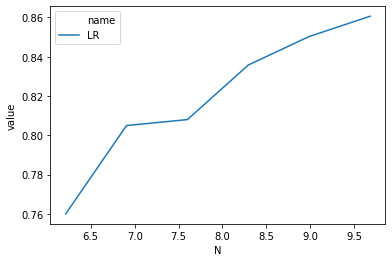

In [73]:
#Using the cross validation scorer from last lecture for different sizes of training data
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
def _cv_score(V, y, models):

    # list of dictionaries with name of model and mean cv score
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):

    # get cv scores for each model at each data level
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]

    # Plot the X axis on log scale so it's easier to see changes
    # with log N observations:
    scores = [({'N': np.log(t), **i}) for t,s
              in zip(ticks, scores) for i in s]

    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

part1LR = [('LR', LogisticRegression())]
plot_cv_scores(V, y, part1LR, [500, 1000, 2000, 4000, 8000, 16000])

In [19]:
#already done
#pip install --upgrade gensim

In [16]:
#Importing the Word2Vec necessary packages
from gensim.models import Word2Vec

In [37]:
V2= ""
for doc in movies.text:
    V2 += doc

In [45]:
processed_article = V2.lower()
processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )
processed_article = re.sub(r'\s+', ' ', processed_article)
# Preparing the dataset

import nltk
nltk.download('punkt')
nltk.download('stopwords')
all_sentences = nltk.sent_tokenize(processed_article)
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

# Removing Stop Words
from nltk.corpus import stopwords
for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\woute\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\woute\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [75]:
# Create document vectors by averaging word vectors. Remove out-of-vocabulary words.
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

In [78]:
# Trying out CBOW with unprocessed text, easier function still
modelCBOW = Word2Vec(list(movies.text), min_count=3,size=75,workers=3, window =3)
def docVecCBOW(doc):
    doc = [word for word in doc if word in modelCBOW.wv.vocab]
    return np.mean(modelCBOW[doc], axis=0)

movies['docVecCBOW'] = movies.text.apply(docVecCBOW)

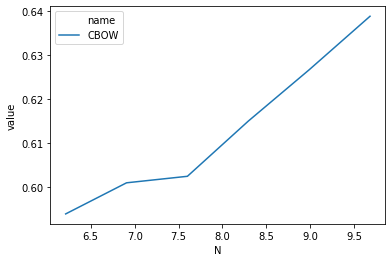

In [80]:
X = list(movies['docVecCBOW'])
part2CBOW = [('CBOW', LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))]
plot_cv_scores(X, y, part2CBOW, [500, 1000, 2000, 4000, 8000, 16000])

In [82]:
# Processing text
def preprocess(doc):
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    doc = nlp(doc)
    words = [token.lemma_ for token in doc]
    words = [w.lower() for w in words]
    words = [w for w in words if w not in stopwords]
    return ' '.join(words).lower()

nlp = spacy.load('en_core_web_sm')
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]') #\d: all doubles
stopwords = ["-pron-", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

v2 = [preprocess(doc) for doc in movies.text]

In [87]:
# Trying out CBOW with processed text, more general function used
modelCBOW2 = Word2Vec(v2, min_count=3,size=75,workers=3, window =3)
movies['docVecCBOW2'] = [document_vector(doc, modelCBOW2) for doc in v2]

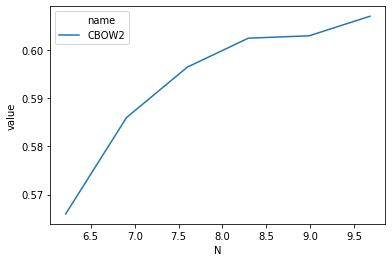

In [88]:
X2 = list(movies['docVecCBOW2'])
part2CBOW2 = [('CBOW2', LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))]
plot_cv_scores(X2, y, part2CBOW2, [500, 1000, 2000, 4000, 8000, 16000])
#Conclusion: works better with actual text --> will compute with actual text for others

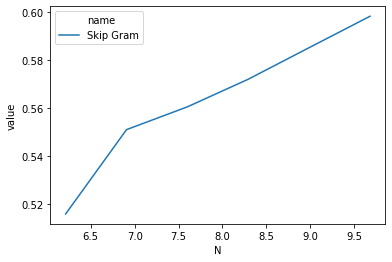

In [91]:
# Trying out Skip Gram with unprocessed text, more general function used
modelSkipGram = Word2Vec(list(movies.text), min_count=3,size=75,workers=3, window =3, sg=1)
movies['docVecSG'] = [document_vector(doc, modelSkipGram) for doc in movies.text]
X = list(movies['docVecSG'])
part2SG = [('Skip Gram', LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))]
plot_cv_scores(X, y, part2SG, [500, 1000, 2000, 4000, 8000, 16000])

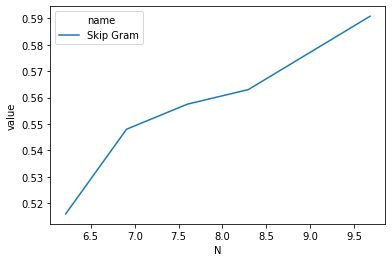

In [92]:
#Now with larger training window size
modelSkipGram = Word2Vec(list(movies.text), min_count=3,size=75,workers=3, window=5, sg=1)
movies['docVecSG'] = [document_vector(doc, modelSkipGram) for doc in movies.text]
X = list(movies['docVecSG'])
part2SG = [('Skip Gram', LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))]
plot_cv_scores(X, y, part2SG, [500, 1000, 2000, 4000, 8000, 16000])

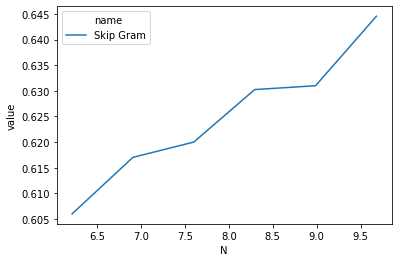

In [93]:
#Now with larger training window size for CBOW as well
modelSkipGram = Word2Vec(list(movies.text), min_count=3,size=75,workers=3, window=5)
movies['docVecSG'] = [document_vector(doc, modelSkipGram) for doc in movies.text]
X = list(movies['docVecSG'])
part2SG = [('Skip Gram', LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'))]
plot_cv_scores(X, y, part2SG, [500, 1000, 2000, 4000, 8000, 16000])



# Conclusions
Having a larger training window size increases results for CBOW but decreases it for Skip Gram. Under these settings, none can compete with the Vectorizer